### Packages Required

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE,f_regression,SelectKBest,f_classif
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVR,SVC
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
#pip install lightgbm
import lightgbm as lgb

### Datasets

In [2]:
Back = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back.csv')
BufferOverflow = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back_BufferOverflow.csv')
GuessPassword = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back_GuessPassword.csv')
Neptune = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back_Neptune.csv')
NMap = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back_NMap.csv')
Normal = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back_Normal.csv')
PortSweep = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back_PortSweep.csv')
RootKit = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back_RootKit.csv')
Satan = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back_Satan.csv')
Smurf = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back_Smurf.csv')
FTPWrite = pd.read_csv('C:/Users/Nithin/Downloads/12. Capstone Case Study - Cyber Security Case Study/Datasets/Data_of_Attack_Back_FTPWrite.csv')

In [3]:
Back['attack'] = 'Back'
BufferOverflow['attack'] = 'BufferOverflow'
GuessPassword['attack'] = 'GuessPassword'
Neptune['attack'] = 'Neptune'
NMap['attack'] = 'NMap'
Normal['attack'] = 'Normal'
PortSweep['attack'] = 'PortSweep'
RootKit['attack'] = 'RootKit'
Satan['attack'] = 'Satan'
Smurf['attack'] = 'Smurf'
FTPWrite['attack'] = 'FTPWrite'

In [4]:
atck = pd.concat([Back,BufferOverflow,GuessPassword,Neptune,NMap,Normal,PortSweep,RootKit,Satan,Smurf],axis = 0)

In [5]:
FTPWrite.columns = Normal.columns

In [6]:
atck = pd.concat([atck,FTPWrite],axis =0,)

In [7]:
atck.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817550 entries, 0 to 6
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   duration                      817550 non-null  float64
 1    protocol_type                817550 non-null  float64
 2    service                      817550 non-null  float64
 3    flag                         817550 non-null  float64
 4    src_bytes                    817550 non-null  float64
 5    dst_bytes                    817550 non-null  float64
 6    land                         817550 non-null  int64  
 7    wrong_fragment               817550 non-null  float64
 8    urgent                       817550 non-null  float64
 9    hot                          817550 non-null  float64
 10   num_failed_logins            817550 non-null  float64
 11   logged_in                    817550 non-null  float64
 12   num_compromised              817550 non-null  fl

In [8]:
atck.isnull().sum()

duration                        0
 protocol_type                  0
 service                        0
 flag                           0
 src_bytes                      0
 dst_bytes                      0
 land                           0
 wrong_fragment                 0
 urgent                         0
 hot                            0
 num_failed_logins              0
 logged_in                      0
 num_compromised                0
 root_shell                     0
 su_attempted                   0
 num_root                       0
 num_file_creations             0
 num_shells                     0
 num_access_files               0
 num_outbound_cmds              0
 is_host_login                  0
 is_guest_login                 0
 count                          0
 srv_count                      0
 serror_rate                    0
 srv_error_rate                 0
 rerror_rate                    0
 srv_rerror_rate                0
 same_srv_rate                  0
 diff_srv_rate

### Binomial Classification

In [9]:
atck_bn = atck.copy()

In [10]:
atck_bn.attack.value_counts()

Normal            576710
Neptune           227228
Satan               5019
Smurf               3007
PortSweep           2964
NMap                1554
Back                 968
GuessPassword         53
BufferOverflow        30
RootKit               10
FTPWrite               7
Name: attack, dtype: int64

In [11]:
atck_bn.attack = np.where(atck_bn.attack=='Normal',0,1)

In [12]:
atck_bn.attack.value_counts()

0    576710
1    240840
Name: attack, dtype: int64

### Continuous & Categorical Variables

In [13]:
atck_bn_cont = atck_bn.select_dtypes(['float64','int64','int32'])
atck_bn_cat = atck_bn.select_dtypes(['object'])

**--Continuous data prepration**

In [14]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max'])

In [15]:
atck_bn_cont.apply(continuous_var_summary).head(8)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
dtype,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
cardinality,918,3,67,11,5908,18399,1,2,5,11,...,256,101,101,101,68,101,97,101,101,2
n_tot,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
n,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
nmiss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,716.8321,465.68,43255.53,16481.5,4056.18326,20326.02873,0,0.3,2.1,2007.5,...,132158.194,54607.921,2763.32,5026.082,1375.607,20328.601,20317.676,4392.049,4315.787,240840
mean,0.000877,0.00057,0.052909,0.02016,0.004961,0.024862,0.0,0.0,0.000003,0.002456,...,0.161652,0.066795,0.00338,0.006148,0.001683,0.024865,0.024852,0.005372,0.005279,0.294587


**--Outlier Treatment**

<AxesSubplot:>

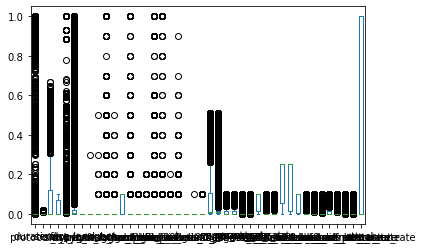

In [16]:
atck_bn_cont.plot(kind='box')

In [17]:
atck_bn_cont = atck_bn_cont.apply(lambda x : x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99)))

<AxesSubplot:>

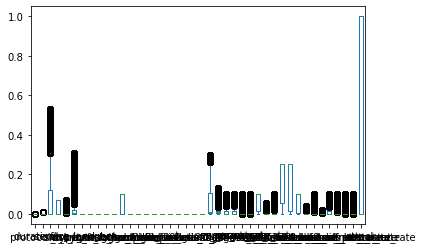

In [18]:
atck_bn_cont.plot(kind='box')

In [19]:
atck_bn_cont.apply(continuous_var_summary)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
dtype,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
cardinality,16,2,54,8,4286,16656,1,1,1,1,...,255,101,41,101,19,101,97,101,101,2
n_tot,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
n,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
nmiss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,21.4284,409.85,42912.3,16449.92,2726.17776,18729.819773,0,0.0,0.0,0.0,...,132158.21,54607.921,2467.165,5026.082,1293.403,20328.601,20317.676,4392.049,4315.787,240840
mean,0.000026,0.000501,0.052489,0.020121,0.003335,0.02291,0.0,0.0,0.0,0.0,...,0.161652,0.066795,0.003018,0.006148,0.001582,0.024865,0.024852,0.005372,0.005279,0.294587
std,0.000172,0.002182,0.094158,0.030887,0.008239,0.049703,0.0,0.0,0.0,0.0,...,0.111642,0.043421,0.005348,0.017459,0.002782,0.043062,0.043151,0.02192,0.02207,0.455857
var,0.0,0.000005,0.008866,0.000954,0.000068,0.00247,0.0,0.0,0.0,0.0,...,0.012464,0.001885,0.000029,0.000305,0.000008,0.001854,0.001862,0.00048,0.000487,0.207806


In [20]:
atck_bn_cont.columns = atck_bn_cont.columns.str.replace(' ','')
atck_bn_cat.columns = atck_bn_cat.columns.str.replace(' ','')

<AxesSubplot:>

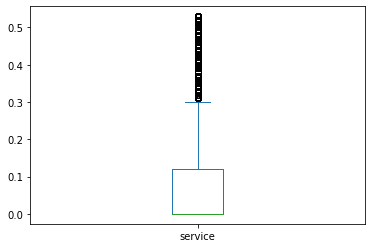

In [21]:
atck_bn_cont.service.plot(kind='box')

In [22]:
#Outlier capping @ 90%
atck_bn_cont.service = np.where(atck_bn_cont.service >=0.12,0.12,atck_bn_cont.service)

<AxesSubplot:>

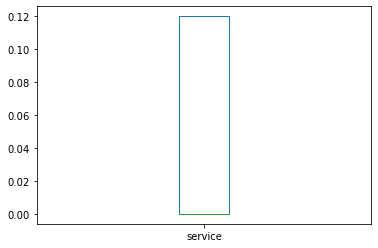

In [23]:
atck_bn_cont.service.plot(kind='box')

**--Missing Value Treatment**

In [24]:
def missing_imputation( x, stats = 'mean' ):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

<AxesSubplot:>

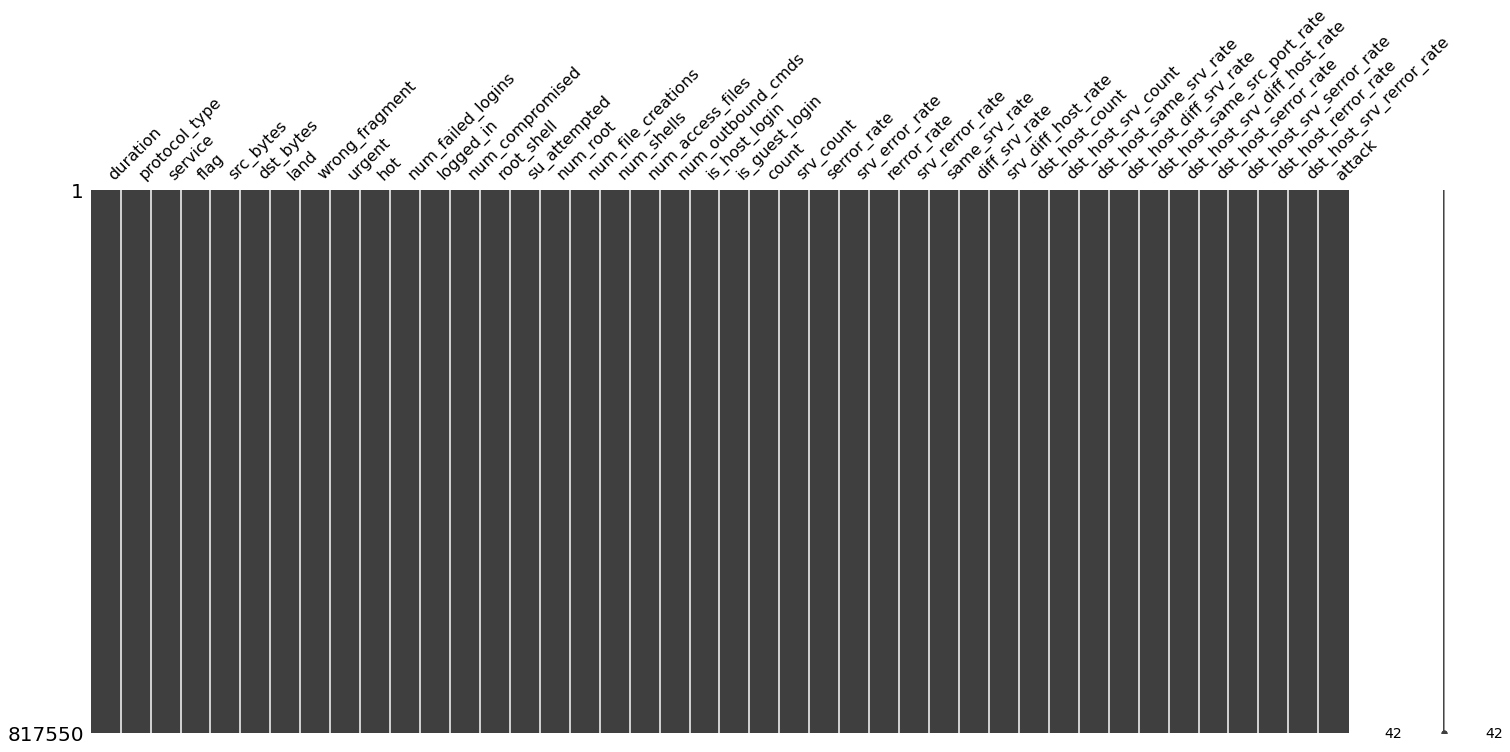

In [25]:
msno.matrix(atck_bn_cont)

In [26]:
atck_bn_cont = atck_bn_cont.apply(missing_imputation).round(2)

<AxesSubplot:>

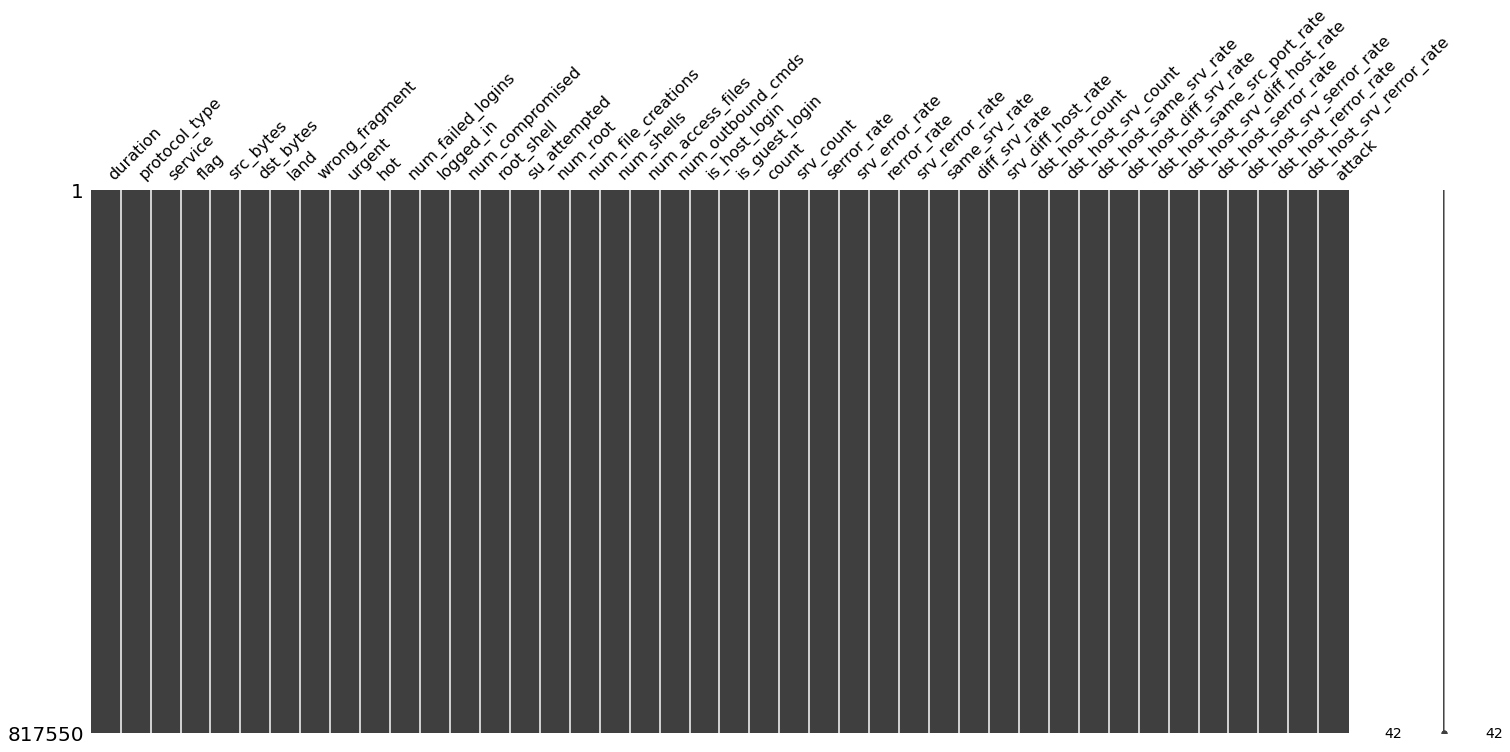

In [27]:
msno.matrix(atck_bn_cont)

In [28]:
atck_bn_cont.apply(continuous_var_summary)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
dtype,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
cardinality,1,2,13,8,8,32,1,1,1,1,...,27,11,5,11,3,11,11,11,11,2
n_tot,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
n,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
nmiss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,0.0,409.85,32226.29,16449.92,1561.57,18364.4,0,0.0,0.0,0.0,...,134197.47,54375.14,2721.81,4558.97,584.67,20294.78,20285.12,4362.44,4296.71,240840
mean,0.0,0.000501,0.039418,0.020121,0.00191,0.022463,0.0,0.0,0.0,0.0,...,0.164146,0.06651,0.003329,0.005576,0.000715,0.024824,0.024812,0.005336,0.005256,0.294587
std,0.0,0.002182,0.054224,0.030887,0.008509,0.049993,0.0,0.0,0.0,0.0,...,0.113893,0.043997,0.006132,0.017567,0.003058,0.043088,0.043175,0.02193,0.0221,0.455857
var,0.0,0.000005,0.00294,0.000954,0.000072,0.002499,0.0,0.0,0.0,0.0,...,0.012972,0.001936,0.000038,0.000309,0.000009,0.001857,0.001864,0.000481,0.000488,0.207806


**--Categorical data prepration**

In [29]:
atck_bn_cat.columns

Index([], dtype='object')

In [30]:
##No categorical columns

**--Final dataset**    

In [31]:
atck_bn_final = pd.concat([atck_bn_cont,atck_bn_cat],axis = 1)

**--Corel Matrix**

<AxesSubplot:>

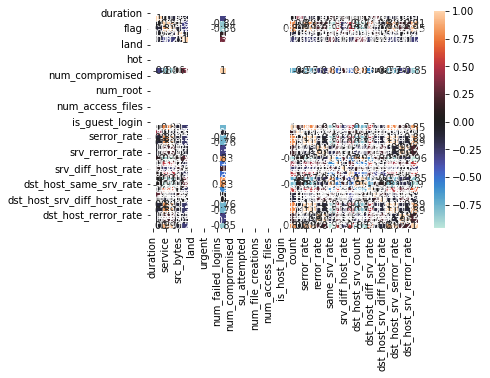

In [32]:
sns.heatmap(atck_bn_final.corr(),cmap='icefire',annot=True)

### Feature Reduction

**--Somer's D**

In [ ]:
somersd_df = pd.DataFrame()
for num_variable in atck_bn_final.columns.difference(['attack']):
    result = smf.logit(formula = str('attack ~ ')+str(num_variable), data=atck_bn_final).fit()
    somers_d = 2*metrics.roc_auc_score(atck_bn_final.attack, result.predict()) - 1
    temp = pd.DataFrame([num_variable,somers_d]).T
    temp.columns = ['VariableName', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

In [34]:
feat_somd = somersd_df.sort_values('SomersD', ascending=False).head(20)
feat_somd

,VariableName,SomersD
0,dst_host_same_srv_rate,0.967138
0,dst_host_srv_count,0.95974
0,count,0.944955
0,dst_host_serror_rate,0.849511
0,dst_host_srv_serror_rate,0.842315
0,dst_host_diff_srv_rate,0.80231
0,diff_srv_rate,0.800317
0,dst_host_count,0.663078
0,dst_bytes,0.631995
0,dst_host_same_src_port_rate,0.184048


**--Select K Best**

In [35]:
X = atck_bn_final[atck_bn_final.columns.difference(['attack'])]
skb = SelectKBest(f_classif, k=20).fit(X, atck_bn_final[['attack']] )

C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [13 15 16 17 18 20 21 22 23 24 25 26 29 38 39 40] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [36]:
feat_skb = list(X.columns[skb.get_support()])
feat_skb

['count',
 'diff_srv_rate',
 'dst_bytes',
 'dst_host_count',
 'dst_host_diff_srv_rate',
 'dst_host_rerror_rate',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_count',
 'dst_host_srv_rerror_rate',
 'dst_host_srv_serror_rate',
 'flag',
 'logged_in',
 'rerror_rate',
 'same_srv_rate',
 'serror_rate',
 'service',
 'srv_diff_host_rate',
 'srv_error_rate',
 'srv_rerror_rate']

In [37]:
feat = list(set(list(feat_somd.VariableName)+feat_skb))
feat

['dst_bytes',
 'same_srv_rate',
 'dst_host_rerror_rate',
 'rerror_rate',
 'flag',
 'dst_host_srv_serror_rate',
 'count',
 'dst_host_srv_diff_host_rate',
 'srv_rerror_rate',
 'dst_host_same_src_port_rate',
 'dst_host_count',
 'dst_host_serror_rate',
 'serror_rate',
 'srv_error_rate',
 'dst_host_diff_srv_rate',
 'logged_in',
 'dst_host_srv_rerror_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_same_srv_rate',
 'service',
 'dst_host_srv_count']

**--VIF**

In [38]:
feature=feat.copy()
a=np.inf
while a>=5:
    vif=[variance_inflation_factor(atck_bn_final[feature].values,i) for i in range(atck_bn_final[feature].shape[1])]
    vif=pd.Series(vif,name='VIF')
    fet=pd.Series(atck_bn_final[feature].columns,name='Feature')
    vifdf=pd.concat([vif,fet],axis=1).sort_values(by="VIF")
    a=vifdf['VIF'].max()
    if a<=5:
        break
    feature=list(vifdf[:-1]["Feature"])

In [39]:
atck_bn_final = atck_bn_final[feature]

In [40]:
atck_bn_final = pd.concat([atck_bn_final,atck_bn.attack],axis = 1)
atck_bn_final

,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,srv_diff_host_rate,dst_bytes,srv_rerror_rate,diff_srv_rate,dst_host_diff_srv_rate,logged_in,dst_host_count,count,attack
0,0.10,0.00,0.10,0.08,0.05,0.0,0.00,0.1,0.0,0.0,1
1,0.05,0.00,0.07,0.08,0.03,0.0,0.00,0.1,0.0,0.0,1
2,0.03,0.00,0.05,0.08,0.02,0.0,0.00,0.1,0.0,0.0,1
3,0.02,0.00,0.00,0.08,0.00,0.0,0.00,0.1,0.0,0.0,1
4,0.02,0.00,0.00,0.08,0.00,0.0,0.00,0.1,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2,0.10,0.00,0.00,0.00,0.00,0.0,0.00,0.1,0.0,0.0,1
3,0.10,0.00,0.00,0.00,0.00,0.0,0.00,0.1,0.0,0.0,1
4,0.05,0.00,0.00,0.03,0.00,0.0,0.04,0.1,0.0,0.0,1
5,0.10,0.02,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1


### Train Test Split Data

In [41]:
X = atck_bn_final.drop('attack',axis=1)
Y = atck_bn_final.attack

In [42]:
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.3,random_state=123)

### Scaling the Dataset

In [43]:
sc = StandardScaler()
train_x_std = sc.fit_transform(train_x)
train_x_std = pd.DataFrame(train_x_std,columns=train_x.columns)
test_x_std = sc.transform(test_x)
test_x_std = pd.DataFrame(test_x_std,columns=test_x.columns)

### Random Forest Classifier

In [44]:
M_rf = RandomForestClassifier()
M_rf.fit(train_x_std,train_y)

RandomForestClassifier()

In [45]:
train_pred = M_rf.predict(train_x_std)
test_pred = M_rf.predict(test_x_std)

**--Model Scoring**

In [46]:
#Evaluation --> Train
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))

MAE: 0.007601107839625362
MSE: 0.007601107839625362
RMSE: 0.08718433253529766


In [47]:
#Evaluation --> Test
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))

MAE: 0.00807697796261187
MSE: 0.00807697796261187
RMSE: 0.08987200878255626


**--Hyper Parameter Tuning**

In [52]:
params = {'n_estimators':[50,100] ,
          'max_depth':[2,3,4], 
          'max_features':[4,5,6]}

In [53]:
grd = GridSearchCV(RandomForestClassifier(),param_grid=params,n_jobs=1,cv=3,
                   scoring='neg_mean_absolute_percentage_error')
grd.fit(train_x_std,train_y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': [2, 3, 4], 'max_features': [4, 5, 6],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_absolute_percentage_error')

In [54]:
grd.best_params_

{'max_depth': 4, 'max_features': 5, 'n_estimators': 50}

**--Best Hyper Parameter**

In [48]:
M_rf = RandomForestClassifier(n_estimators=50,n_jobs=1,max_depth=4,max_features=5)
M_rf.fit(train_x_std,train_y)

RandomForestClassifier(max_depth=4, max_features=5, n_estimators=50, n_jobs=1)

In [49]:
train_pred = M_rf.predict(train_x_std)
test_pred = M_rf.predict(test_x_std)

**--Model Scoring**

In [50]:
#Evaluation --> Train
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))
print('Class_Report:',metrics.classification_report(train_y,train_pred))

MAE: 0.012423879710284212
MSE: 0.012423879710284212
RMSE: 0.11146245874860383
Class_Report:               precision    recall  f1-score   support

           0       0.99      0.99      0.99    403464
           1       0.98      0.98      0.98    168821

    accuracy                           0.99    572285
   macro avg       0.98      0.99      0.99    572285
weighted avg       0.99      0.99      0.99    572285



In [51]:
#Evaluation --> Test
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))
print('Class_Report:',metrics.classification_report(test_y,test_pred))

MAE: 0.012406988359529489
MSE: 0.012406988359529489
RMSE: 0.1113866614973691
Class_Report:               precision    recall  f1-score   support

           0       0.99      0.99      0.99    173246
           1       0.98      0.98      0.98     72019

    accuracy                           0.99    245265
   macro avg       0.98      0.99      0.99    245265
weighted avg       0.99      0.99      0.99    245265



### XG Classifier

In [52]:
M_xg = XGBClassifier()
M_xg.fit(train_x_std,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [53]:
train_pred = M_xg.predict(train_x_std)
test_pred = M_xg.predict(test_x_std)

**--Model Scoring**

In [54]:
#Evaluation --> Train
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))

MAE: 0.007735656185292293
MSE: 0.007735656185292293
RMSE: 0.08795257918499202


In [55]:
#Evaluation --> Test
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))

MAE: 0.008044360181844127
MSE: 0.008044360181844127
RMSE: 0.08969035724002958


**--Hyper Parameter Tuning**

In [56]:
params =  {'n_estimators':[50,100],
            'learning_rate': [0.1,0.2,0.3],
            'gamma':[0.1,0.2],
            'max_depth':[2,3,4]}

In [57]:
grd = GridSearchCV(XGBClassifier(),param_grid=params,n_jobs=1,cv=3,
                   scoring='neg_mean_absolute_percentage_error')
grd.fit(train_x_std,train_y)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'gamma': [0.1, 0.2], 'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 3, 4], 'n_estimators': [50, 100]},
             scoring='neg_mean_absolute_percentage_error')

In [58]:
grd.best_params_

{'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}

**--Best Hyper Parameter**

In [59]:
M_xg = XGBClassifier(n_estimators=100,learning_rate=0.3,gamma=0.1,max_depth=4)
M_xg.fit(train_x_std,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [60]:
train_pred = M_xg.predict(train_x_std)
test_pred = M_xg.predict(test_x_std)

**--Model Scoring**

In [61]:
#Evaluation --> Train
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))
print('Class_Report:',metrics.classification_report(train_y,train_pred))

MAE: 0.008004752876626156
MSE: 0.008004752876626156
RMSE: 0.08946928454294331
Class_Report:               precision    recall  f1-score   support

           0       1.00      0.99      0.99    403464
           1       0.98      0.99      0.99    168821

    accuracy                           0.99    572285
   macro avg       0.99      0.99      0.99    572285
weighted avg       0.99      0.99      0.99    572285



In [62]:
#Evaluation --> Test
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))
print('Class_Report:',metrics.classification_report(test_y,test_pred))

MAE: 0.008207449085682833
MSE: 0.008207449085682833
RMSE: 0.0905949727395667
Class_Report:               precision    recall  f1-score   support

           0       1.00      0.99      0.99    173246
           1       0.98      0.99      0.99     72019

    accuracy                           0.99    245265
   macro avg       0.99      0.99      0.99    245265
weighted avg       0.99      0.99      0.99    245265



### Multinomial Classification

In [83]:
atck_mn = atck.copy()

In [84]:
atck_mn.attack.value_counts()

Normal            576710
Neptune           227228
Satan               5019
Smurf               3007
PortSweep           2964
NMap                1554
Back                 968
GuessPassword         53
BufferOverflow        30
RootKit               10
FTPWrite               7
Name: attack, dtype: int64

In [85]:
atck_mn.attack = np.where(atck_mn.attack=='normal',0,
                    np.where((atck_mn.attack=='Neptune'),1,
                    np.where((atck_mn.attack=='Satan'),2,
                    np.where((atck_mn.attack=='Smurf'),3,
                    np.where((atck_mn.attack=='PortSweep'),4,
                    np.where((atck_mn.attack=='NMap'),5,
                    np.where((atck_mn.attack=='Back'),6,
                    np.where((atck_mn.attack=='GuessPassword'),7,
                    np.where((atck_mn.attack=='BufferOverflow'),8,
                    np.where((atck_mn.attack=='RootKit'),9,
                    np.where((atck_mn.attack=='FTPWrite'),10,0)))))))))))    
atck_mn.attack.value_counts()

0     576710
1     227228
2       5019
3       3007
4       2964
5       1554
6        968
7         53
8         30
9         10
10         7
Name: attack, dtype: int64

### Continuous & Categorical Variables

In [87]:
atck_mn_cont = atck_mn.select_dtypes(['float64','int64','int32'])
atck_mn_cat = atck_mn.select_dtypes(['object'])

**--Continuous data prepration**

In [88]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max'])

In [89]:
atck_mn_cont.apply(continuous_var_summary).head(8)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
dtype,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
cardinality,918,3,67,11,5908,18399,1,2,5,11,...,256,101,101,101,68,101,97,101,101,11
n_tot,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
n,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
nmiss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,716.8321,465.68,43255.53,16481.5,4056.18326,20326.02873,0,0.3,2.1,2007.5,...,132158.194,54607.921,2763.32,5026.082,1375.607,20328.601,20317.676,4392.049,4315.787,272492
mean,0.000877,0.00057,0.052909,0.02016,0.004961,0.024862,0.0,0.0,0.000003,0.002456,...,0.161652,0.066795,0.00338,0.006148,0.001683,0.024865,0.024852,0.005372,0.005279,0.333303


**--Outlier Treatment**

<AxesSubplot:>

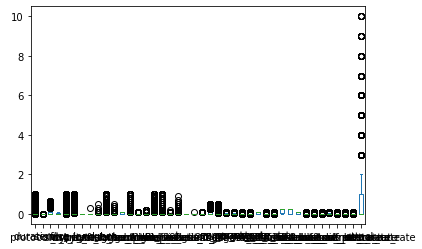

In [90]:
atck_mn_cont.plot(kind='box')

In [91]:
atck_mn_cont = atck_mn_cont.apply(lambda x : x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99)))

<AxesSubplot:>

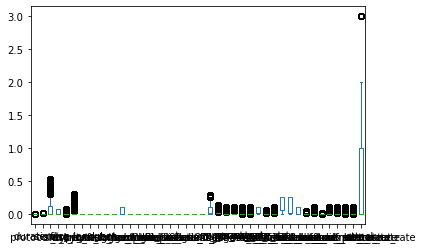

In [92]:
atck_mn_cont.plot(kind='box')

In [19]:
atck_mn_cont.apply(continuous_var_summary)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
dtype,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
cardinality,16,2,54,8,4286,16656,1,1,1,1,...,255,101,41,101,19,101,97,101,101,2
n_tot,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
n,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
nmiss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,21.4284,409.85,42912.3,16449.92,2726.17776,18729.819773,0,0.0,0.0,0.0,...,132158.21,54607.921,2467.165,5026.082,1293.403,20328.601,20317.676,4392.049,4315.787,240840
mean,0.000026,0.000501,0.052489,0.020121,0.003335,0.02291,0.0,0.0,0.0,0.0,...,0.161652,0.066795,0.003018,0.006148,0.001582,0.024865,0.024852,0.005372,0.005279,0.294587
std,0.000172,0.002182,0.094158,0.030887,0.008239,0.049703,0.0,0.0,0.0,0.0,...,0.111642,0.043421,0.005348,0.017459,0.002782,0.043062,0.043151,0.02192,0.02207,0.455857
var,0.0,0.000005,0.008866,0.000954,0.000068,0.00247,0.0,0.0,0.0,0.0,...,0.012464,0.001885,0.000029,0.000305,0.000008,0.001854,0.001862,0.00048,0.000487,0.207806


In [93]:
atck_mn_cont.columns = atck_mn_cont.columns.str.replace(' ','')
atck_mn_cat.columns = atck_mn_cat.columns.str.replace(' ','')

<AxesSubplot:>

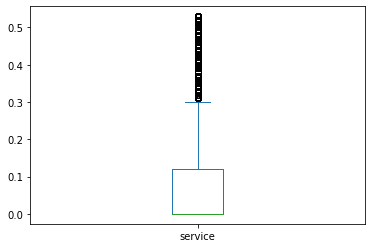

In [94]:
atck_mn_cont.service.plot(kind='box')

In [95]:
#Outlier capping @ 90%
atck_mn_cont.service = np.where(atck_mn_cont.service >=0.12,0.12,atck_bn_cont.service)

<AxesSubplot:>

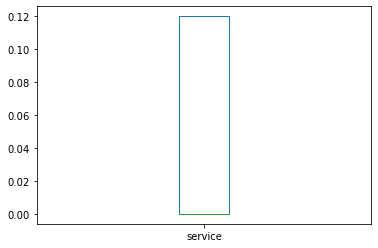

In [96]:
atck_mn_cont.service.plot(kind='box')

**--Missing Value Treatment**

In [97]:
def missing_imputation( x, stats = 'mean' ):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

<AxesSubplot:>

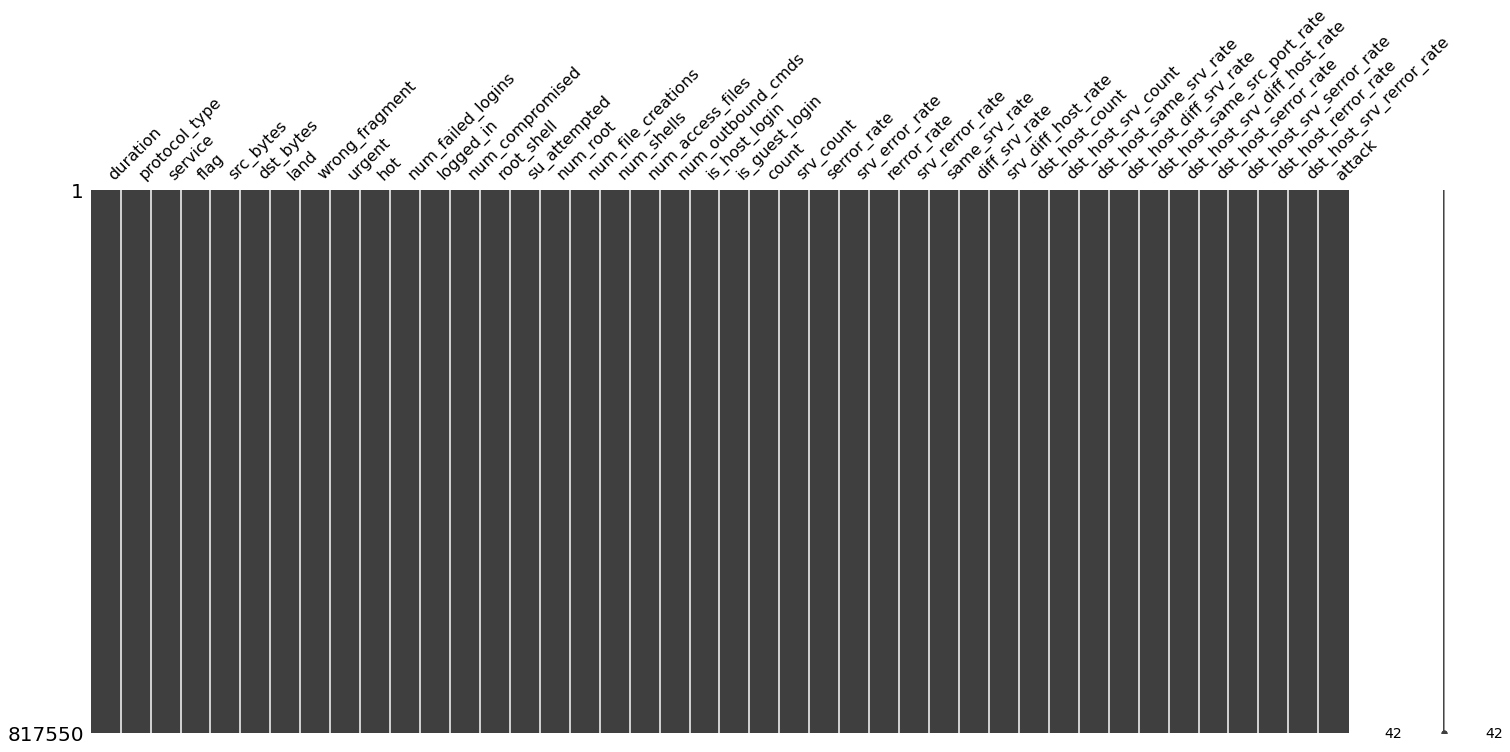

In [98]:
msno.matrix(atck_mn_cont)

In [99]:
atck_mn_cont = atck_mn_cont.apply(missing_imputation).round(2)

<AxesSubplot:>

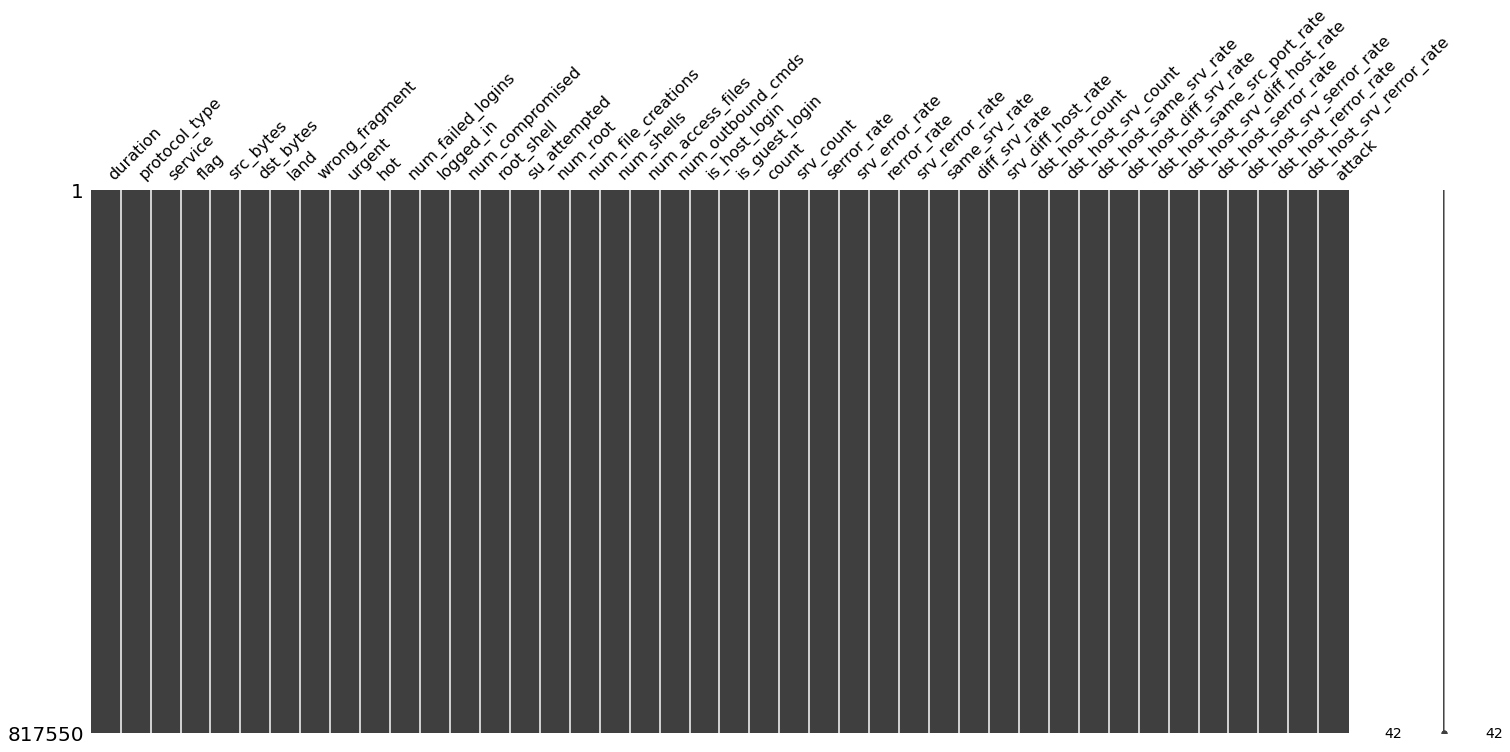

In [100]:
msno.matrix(atck_mn_cont)

In [101]:
atck_mn_cont.apply(continuous_var_summary)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
dtype,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,1,2,13,8,8,32,1,1,1,1,...,27,11,5,11,3,11,11,11,11,4
n_tot,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
n,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550,...,817550,817550,817550,817550,817550,817550,817550,817550,817550,817550
nmiss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,0.0,409.85,32226.29,16449.92,1561.57,18364.4,0,0.0,0.0,0.0,...,134197.47,54375.14,2721.81,4558.97,584.67,20294.78,20285.12,4362.44,4296.71,263045.0
mean,0.0,0.000501,0.039418,0.020121,0.00191,0.022463,0.0,0.0,0.0,0.0,...,0.164146,0.06651,0.003329,0.005576,0.000715,0.024824,0.024812,0.005336,0.005256,0.321748
std,0.0,0.002182,0.054224,0.030887,0.008509,0.049993,0.0,0.0,0.0,0.0,...,0.113893,0.043997,0.006132,0.017567,0.003058,0.043088,0.043175,0.02193,0.0221,0.54182
var,0.0,0.000005,0.00294,0.000954,0.000072,0.002499,0.0,0.0,0.0,0.0,...,0.012972,0.001936,0.000038,0.000309,0.000009,0.001857,0.001864,0.000481,0.000488,0.293569


**--Categorical data prepration**

In [102]:
atck_mn_cat.columns

Index([], dtype='object')

In [30]:
##No categorical columns

**--Final dataset**    

In [121]:
atck_mn_final = pd.concat([atck_mn_cont,atck_mn_cat],axis = 1)

In [122]:
atck_mn_final.attack = atck_mn.attack

**--Corel Matrix**

<AxesSubplot:>

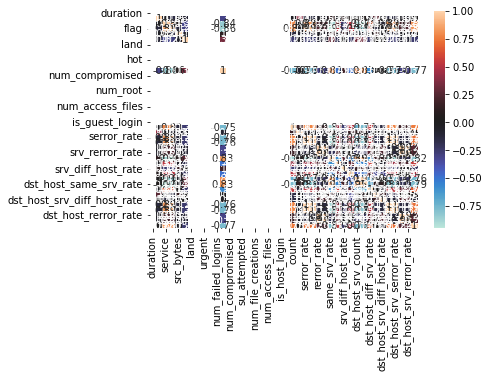

In [104]:
sns.heatmap(atck_mn_final.corr(),cmap='icefire',annot=True)

### Feature Reduction

**--Somer's D**

In [ ]:
somersd_df = pd.DataFrame()
for num_variable in atck_mn_final.columns.difference(['attack']):
    result = smf.logit(formula = str('attack ~ ')+str(num_variable), data= atck_mn_final).fit()
    somers_d = 2*metrics.roc_auc_score(atck_mn_final.attack, result.predict()) - 1
    temp = pd.DataFrame([num_variable,somers_d]).T
    temp.columns = ['VariableName', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

In [34]:
feat_somd = somersd_df.sort_values('SomersD', ascending=False).head(20)
feat_somd

,VariableName,SomersD
0,dst_host_same_srv_rate,0.967138
0,dst_host_srv_count,0.95974
0,count,0.944955
0,dst_host_serror_rate,0.849511
0,dst_host_srv_serror_rate,0.842315
0,dst_host_diff_srv_rate,0.80231
0,diff_srv_rate,0.800317
0,dst_host_count,0.663078
0,dst_bytes,0.631995
0,dst_host_same_src_port_rate,0.184048


**--Select K Best**

In [128]:
X = atck_mn_final[atck_mn_final.columns.difference(['attack'])]
skb = SelectKBest(f_classif, k=25).fit(X, atck_mn_final[['attack']] )

C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [13 15 16 17 18 20 21 22 23 24 25 26 29 38 39 40] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [129]:
feat_skb = list(X.columns[skb.get_support()])
feat_skb

['count',
 'diff_srv_rate',
 'dst_bytes',
 'dst_host_count',
 'dst_host_diff_srv_rate',
 'dst_host_rerror_rate',
 'dst_host_same_src_port_rate',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_count',
 'dst_host_srv_diff_host_rate',
 'dst_host_srv_rerror_rate',
 'dst_host_srv_serror_rate',
 'flag',
 'logged_in',
 'protocol_type',
 'rerror_rate',
 'same_srv_rate',
 'serror_rate',
 'service',
 'src_bytes',
 'srv_count',
 'srv_diff_host_rate',
 'srv_error_rate',
 'srv_rerror_rate']

In [130]:
feat = list(set(feat_skb))
feat

['protocol_type',
 'dst_bytes',
 'same_srv_rate',
 'dst_host_rerror_rate',
 'rerror_rate',
 'flag',
 'dst_host_srv_serror_rate',
 'count',
 'dst_host_srv_diff_host_rate',
 'srv_rerror_rate',
 'dst_host_same_src_port_rate',
 'dst_host_count',
 'dst_host_serror_rate',
 'src_bytes',
 'serror_rate',
 'srv_error_rate',
 'dst_host_diff_srv_rate',
 'logged_in',
 'dst_host_srv_rerror_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_same_srv_rate',
 'service',
 'dst_host_srv_count',
 'srv_count']

**--VIF**

In [131]:
feature=feat.copy()
a=np.inf
while a>=5:
    vif=[variance_inflation_factor(atck_mn_final[feature].values,i) for i in range(atck_mn_final[feature].shape[1])]
    vif=pd.Series(vif,name='VIF')
    fet=pd.Series(atck_mn_final[feature].columns,name='Feature')
    vifdf=pd.concat([vif,fet],axis=1).sort_values(by="VIF")
    a=vifdf['VIF'].max()
    if a<=5:
        break
    feature=list(vifdf[:-1]["Feature"])

In [132]:
atck_mn_final = atck_mn_final[feature]

In [133]:
atck_mn_final = pd.concat([atck_mn_final,atck_mn.attack],axis = 1)
atck_mn_final

,src_bytes,dst_host_srv_diff_host_rate,srv_diff_host_rate,dst_bytes,dst_host_same_src_port_rate,diff_srv_rate,protocol_type,srv_rerror_rate,srv_count,dst_host_diff_srv_rate,logged_in,count,dst_host_count,attack
0,0.07,0.00,0.10,0.08,0.10,0.0,0.0,0.05,0.0,0.00,0.1,0.0,0.0,6
1,0.07,0.00,0.07,0.08,0.05,0.0,0.0,0.03,0.0,0.00,0.1,0.0,0.0,6
2,0.07,0.00,0.05,0.08,0.03,0.0,0.0,0.02,0.0,0.00,0.1,0.0,0.0,6
3,0.07,0.00,0.00,0.08,0.02,0.0,0.0,0.00,0.0,0.00,0.1,0.0,0.0,6
4,0.07,0.00,0.00,0.08,0.02,0.0,0.0,0.00,0.0,0.00,0.1,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,0.00,0.00,0.00,0.00,0.10,0.0,0.0,0.00,0.0,0.00,0.1,0.0,0.0,10
3,0.00,0.00,0.00,0.00,0.10,0.0,0.0,0.00,0.0,0.00,0.1,0.0,0.0,10
4,0.00,0.00,0.00,0.03,0.05,0.0,0.0,0.00,0.0,0.04,0.1,0.0,0.0,10
5,0.01,0.02,0.00,0.00,0.10,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,10


### Train Test Split Data

In [134]:
X = atck_mn_final.drop('attack',axis=1)
Y = atck_mn_final.attack

In [135]:
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.3,random_state=123)

### Scaling the Dataset

In [136]:
sc = StandardScaler()
train_x_std = sc.fit_transform(train_x)
train_x_std = pd.DataFrame(train_x_std,columns=train_x.columns)
test_x_std = sc.transform(test_x)
test_x_std = pd.DataFrame(test_x_std,columns=test_x.columns)

### Decission Tree Classifier

In [137]:
M_dt = DecisionTreeClassifier()
M_dt.fit(train_x_std,train_y)

DecisionTreeClassifier()

In [138]:
train_pred = M_dt.predict(train_x_std)
test_pred = M_dt.predict(test_x_std)

**--Model Scoring**

In [139]:
#Evaluation --> Train
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))

MAE: 0.0022174266318355364
MSE: 0.011597368444044489
RMSE: 0.10769107875791982


In [140]:
#Evaluation --> Test
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))

MAE: 0.003094611950339429
MSE: 0.0161335698122439
RMSE: 0.12701799011259743


**--Hyper Parameter Tuning**

In [141]:
params = {
    'max_depth':[3,4,5],
    'max_features':[11,12,13],
    'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]}

In [142]:
grd = GridSearchCV(DecisionTreeClassifier(),param_grid=params,n_jobs=1,cv=3,
                   scoring='neg_mean_absolute_percentage_error')
grd.fit(train_x_std,train_y)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'max_depth': [3, 4, 5], 'max_features': [11, 12, 13],
                         'min_impurity_decrease': [5e-05, 0.0001, 0.0002,
                                                   0.0005, 0.001, 0.0015, 0.002,
                                                   0.005, 0.01]},
             scoring='neg_mean_absolute_percentage_error')

In [143]:
grd.best_params_

{'max_depth': 5, 'max_features': 13, 'min_impurity_decrease': 0.0005}

**--Best Hyper Parameter**

In [144]:
M_dt = DecisionTreeClassifier(max_depth=5,max_features=13,min_impurity_decrease=0.0005)
M_dt.fit(train_x_std,train_y)

DecisionTreeClassifier(max_depth=5, max_features=13,
                       min_impurity_decrease=0.0005)

In [145]:
train_pred = M_dt.predict(train_x_std)
test_pred = M_dt.predict(test_x_std)

**--Model Scoring**

In [146]:
#Evaluation --> Train
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))
print('Class_Report:',metrics.classification_report(train_y,train_pred))

MAE: 0.024388198187965785
MSE: 0.1163353923307443
RMSE: 0.3410797448262566


C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class_Report:               precision    recall  f1-score   support

           0       0.99      1.00      1.00    403464
           1       1.00      1.00      1.00    159248
           2       1.00      0.84      0.91      3531
           3       1.00      0.94      0.97      2110
           4       0.97      0.79      0.87      2076
           5       0.00      0.00      0.00      1112
           6       0.00      0.00      0.00       673
           7       0.00      0.00      0.00        40
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         4

    accuracy                           0.99    572285
   macro avg       0.45      0.42      0.43    572285
weighted avg       0.99      0.99      0.99    572285



C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [147]:
#Evaluation --> Test
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))
print('Class_Report:',metrics.classification_report(test_y,test_pred))

MAE: 0.024491876133977533
MSE: 0.11571565449615721
RMSE: 0.3401700376225943


C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class_Report:               precision    recall  f1-score   support

           0       0.99      1.00      1.00    173246
           1       1.00      1.00      1.00     67980
           2       1.00      0.83      0.90      1488
           3       1.00      0.94      0.97       897
           4       0.96      0.76      0.85       888
           5       0.00      0.00      0.00       442
           6       0.00      0.00      0.00       295
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         3

    accuracy                           0.99    245265
   macro avg       0.45      0.41      0.43    245265
weighted avg       0.99      0.99      0.99    245265



C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XG Classifier

In [148]:
M_xg = XGBClassifier()
M_xg.fit(train_x_std,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [149]:
train_pred = M_xg.predict(train_x_std)
test_pred = M_xg.predict(test_x_std)

**--Model Scoring**

In [150]:
#Evaluation --> Train
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))

MAE: 0.0023065430685759716
MSE: 0.012028971578846205
RMSE: 0.10967666834311755


In [151]:
#Evaluation --> Test
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))

MAE: 0.0029559863820765296
MSE: 0.015122418608443928
RMSE: 0.12297324346557639


**--Hyper Parameter Tuning**

In [152]:
params =  {'n_estimators':[50,100],
            'learning_rate': [0.1,0.2,0.3],
            'gamma':[0.1,0.2],
            'max_depth':[2,3,4]}

In [ ]:
grd = GridSearchCV(XGBClassifier(),param_grid=params,n_jobs=1,cv=3,
                   scoring='neg_mean_absolute_percentage_error')
grd.fit(train_x_std,train_y)

In [58]:
grd.best_params_

{'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}

**--Best Hyper Parameter**

In [154]:
M_xg = XGBClassifier(n_estimators=100,learning_rate=0.3,gamma=0.1,max_depth=4)
M_xg.fit(train_x_std,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [155]:
train_pred = M_xg.predict(train_x_std)
test_pred = M_xg.predict(test_x_std)

**--Model Scoring**

In [156]:
#Evaluation --> Train
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))
print('Class_Report:',metrics.classification_report(train_y,train_pred))

MAE: 0.002584376665472623
MSE: 0.013309801934350891
RMSE: 0.11536811489467483


C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class_Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    403464
           1       1.00      1.00      1.00    159248
           2       1.00      0.99      0.99      3531
           3       1.00      1.00      1.00      2110
           4       0.99      0.98      0.99      2076
           5       0.97      0.91      0.94      1112
           6       1.00      1.00      1.00       673
           7       0.00      0.00      0.00        40
           8       0.92      0.63      0.75        19
           9       0.00      0.00      0.00         8
          10       1.00      0.25      0.40         4

    accuracy                           1.00    572285
   macro avg       0.81      0.71      0.73    572285
weighted avg       1.00      1.00      1.00    572285



C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [157]:
#Evaluation --> Test
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))
print('Class_Report:',metrics.classification_report(test_y,test_pred))

MAE: 0.003045685279187817
MSE: 0.015155036389211668
RMSE: 0.12310579348353866


C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class_Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    173246
           1       1.00      1.00      1.00     67980
           2       0.99      0.98      0.99      1488
           3       1.00      1.00      1.00       897
           4       0.99      0.97      0.98       888
           5       0.94      0.90      0.92       442
           6       1.00      1.00      1.00       295
           7       0.00      0.00      0.00        13
           8       1.00      0.36      0.53        11
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         3

    accuracy                           1.00    245265
   macro avg       0.72      0.66      0.67    245265
weighted avg       1.00      1.00      1.00    245265



C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
